In [7]:
# To add a new cell, type '# %%'
# To add a new markdown cell, type '# %% [markdown]'
# %%
from IPython import get_ipython


In [8]:
import os
import sys
from time import time
# import itertools
from tqdm import tqdm
import numpy as np
import pandas as pd
import random
import string
import re

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import plotly.graph_objs as go
import plotly.express as px
import seaborn as sns

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim.models import word2vec

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.metrics import recall_score, confusion_matrix, classification_report, accuracy_score, plot_confusion_matrix
import lime 
from lime import lime_text
from lime.lime_text import LimeTextExplainer
from sklearn.pipeline import make_pipeline

from sklearn import metrics

import tensorflow as tf

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding
from tensorflow.keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Sequential
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers
from tensorflow.keras.preprocessing import text, sequence

from gensim.models import Phrases
from gensim.models.phrases import Phraser

physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)



Num GPUs Available:  1


In [9]:
get_ipython().system('pip install matplotlib')



ERROR: Could not install packages due to an EnvironmentError: [Errno 2] No such file or directory: 'c:\\users\\juice\\.conda\\envs\\tensorflow\\lib\\site-packages\\matplotlib-3.3.3.dist-info\\METADATA'



In [10]:
def plot_results(results):
  """Function to convert a models results into a dataframe and plot them to show the both the accuracy and validation accuracy, as well as the loss and validation loss over epochs.

  Args:
      results_dataframe (dataframe): 
  """

  results_dataframe = pd.DataFrame(results)

  fig = px.line(results_dataframe, x=results_dataframe.index, y=["accuracy","val_accuracy"])
  fig.update_layout(title='Accuracy and Validation Accuracy over Epochs',
                    xaxis_title='Epoch',
                    yaxis_title='Percentage',
                )
  fig.update_traces(mode='lines+markers')
  fig.show()

  fig = px.line(results_dataframe, x=results_dataframe.index, y=['loss','val_loss'])
  fig.update_layout(title='Loss and Validation Loss over Epochs',
                    xaxis_title='Epoch',
                    yaxis_title='idek what this unit is - change me'
                )
  fig.update_traces(mode='lines+markers')
  fig.show()

def plotImages(images_arr, labels_arr):
    labels_arr = ['Normal: 0' if label == 0 else 'Pneumonia: 1' for label in labels_arr]
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, label, ax in zip(images_arr, 
                              labels_arr, 
                              axes):
        ax.imshow(img)
        ax.set_title(label, size=18)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

def evaluate_results(model): 
    labels = ['East','South', 'Mid-West', 'West']
    predictions = model.predict(X_test).argmax(axis=1)
    cm = metrics.confusion_matrix(y_test.argmax(axis=1), 
                                    predictions,
                                    normalize="pred")

    ax = sns.heatmap(cm, cmap='Blues',annot=True,square=True)
    ax.set(xlabel='Predicted Class',ylabel='True Class')
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    print(metrics.classification_report(y_test.argmax(axis=1), predictions))

# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})"
                  .format(results['mean_test_score'][candidate],
                          results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

def plot_conf_matrix(y_true, y_pred):
    
    """
    Plots a confusion matrix and displays classification report.
    """
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    plt.figure(figsize=(7, 7))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='0.2g', annot_kws={"size": 14},
                xticklabels=nb.classes_, yticklabels=nb.classes_, square=True)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


def evaluate_model(model, X_train, X_test):
    y_preds_train = model.predict(X_train.todense())
    y_preds_test = model.predict(X_test.todense())

    # print('Training Accuracy:', accuracy(y_train, y_preds_train, average='weighted'))
    print('Training Accuracy:', accuracy_score(y_train, y_preds_train))
    print('Testing Accuracy:', accuracy_score(y_test, y_preds_test))
    print('Training Recall:', recall_score(y_train, y_preds_train, average='weighted'))
    print('Testing Recall:', recall_score(y_test, y_preds_test, average='weighted'))
    print('\n---------------\n')
    print('Train Confusion Matrix\n')
    plot_conf_matrix(y_train, y_preds_train)
    print('Test Confusion Matrix\n')
    plot_conf_matrix(y_test, y_preds_test)
    print('\n----------------\n')
    print(classification_report(y_test, y_preds_test))



In [11]:
df = pd.read_csv('../capstone-data/lyrics/lyrics_main.csv',encoding='unicode_escape')
print('-- Dataframe shape: ',df.shape)
print('-- Number of duplicate rows: ',df.duplicated().sum())
print('\n-- Checking for unexpected NUll values-\n',df.isna().sum())
df.head()


-- Dataframe shape:  (9681, 14)
-- Number of duplicate rows:  0

-- Checking for unexpected NUll values-
 album                        0
lyrics_title                 0
lyrics_url                   0
lyrics                       0
track_views               3951
feature                   5209
producer                  1027
release_date                21
album_url                    0
album_art                    0
artist                       0
alternate_artist_names       0
region                       0
region_code                  0
dtype: int64


,album,lyrics_title,lyrics_url,lyrics,track_views,feature,producer,release_date,album_url,album_art,artist,alternate_artist_names,region,region_code
0,4:44,Kill Jay Z,https://genius.com/Jay-z-kill-jay-z-lyrics,"[Verse]\nKill JAY-Z, they'll never love you\nY...",940.8K,NaN,Produced by No I.D.,2017.0,https://genius.com/albums/Jay-z/4-44,https://images.genius.com/938568f8961cba0e4fe3...,JAY-Z 175,"AKA: Shawn Corey Carter, Jay-Hova, Jiggaman, Y...",East,0
1,4:44,The Story of O.J.,https://genius.com/Jay-z-the-story-of-oj-lyrics,"[Intro: Nina Simone]\nSkin is, skin, is\nSkin ...",1.9M,NaN,Produced by No I.D.,2017.0,https://genius.com/albums/Jay-z/4-44,https://images.genius.com/938568f8961cba0e4fe3...,JAY-Z 175,"AKA: Shawn Corey Carter, Jay-Hova, Jiggaman, Y...",East,0
2,4:44,Smile (Ft. Gloria Carter),https://genius.com/Jay-z-smile-lyrics,[Intro: JAY-Z & Stevie Wonder]\nGood morn' or ...,693.6K,Featuring Gloria Carter,Produced by No I.D. & JAY-Z,2017.0,https://genius.com/albums/Jay-z/4-44,https://images.genius.com/938568f8961cba0e4fe3...,JAY-Z 175,"AKA: Shawn Corey Carter, Jay-Hova, Jiggaman, Y...",East,0
3,4:44,Caught Their Eyes (Ft. Frank Ocean),https://genius.com/Jay-z-caught-their-eyes-lyrics,[Intro: Frank Ocean]\nReady for it\nI'm ready ...,409.9K,Featuring Frank Ocean,Produced by No I.D.,2017.0,https://genius.com/albums/Jay-z/4-44,https://images.genius.com/938568f8961cba0e4fe3...,JAY-Z 175,"AKA: Shawn Corey Carter, Jay-Hova, Jiggaman, Y...",East,0
4,4:44,4:44,https://genius.com/Jay-z-4-44-lyrics,[Intro: Hannah Williams]\nDo I find it so hard...,1.8M,NaN,Produced by JAY-Z & No I.D.,2017.0,https://genius.com/albums/Jay-z/4-44,https://images.genius.com/938568f8961cba0e4fe3...,JAY-Z 175,"AKA: Shawn Corey Carter, Jay-Hova, Jiggaman, Y...",East,0


  number of artists
  See how many tracks per artist
  albums per artist
  number of songs with features
  most popular featured artists
  most popular producers
  most popular songs - need to convert track views

In [12]:
artists_to_clean = [
'2 Chainz 8,145',
'Chance the Rapper 47,380',
'Childish Gambino 4,621',
'Common 10,680',
'E-40 2,486',
'Future 4,246',
'Ice Cube 2,636',
'J. Cole 505',
'JAY-Z 175',
'Jeezy 4,855',
'Lil Wayne 4,188',
'Lupe Fiasco 1,619',
'Mac Miller 37,632',
'Nas 37,937',
'Nipsey Hussle 3,475',
'Rick Ross 4,992',
'Royce da 5\'9\" 15,776',
'Snoop Dogg 4,935',
'T.I. 7,556',
'The Game 1,170',
'Too $hort 3,022',
'Travis Scott 3,948'
]


df.artist = df.artist.apply(lambda x: x.replace(x, str(x.split(' ')[:-1])).replace("['",'').replace("']",'').replace("', '", " ").replace('\\','') if x in artists_to_clean else x)



In [13]:
df.track_views = df.track_views.fillna('0M')
df.track_views = df.track_views.apply(lambda x: float(x.replace('M','')) * 1000000 if 'M' in x else (float(x.replace('K',''))) * 1000)
df.track_views = df.track_views.astype('int64')
df.release_date = df.release_date.fillna(0)
df.release_date = df.release_date.astype('int64')



In [14]:
# df.head()



In [15]:
# df.to_csv('../capstone-data/lyrics/lyrics_main_edited.csv')



In [16]:
df_trimmed = df[['region', 'lyrics']]



In [17]:
df, df_test = train_test_split(df_trimmed, test_size=.2, shuffle=True, random_state=42)



In [18]:
def clean_lyrics(lyrics):
    
    ## Convert words to lower case and split them
    lyrics = lyrics.lower().split()
    
    ## Remove stop words
    stopwords_list = stopwords.words("english")
    stopwords_list += string.punctuation
    lyrics = [w for w in lyrics if not w in stopwords_list]
    # stopword_list = stopwords.words('english')
    # stopword_list += string.punctuation
    
    lyrics = " ".join(lyrics)
    ## Clean the lyrics
    lyrics = re.sub(r"\[[^\]]*\]", " ", lyrics)
    lyrics = re.sub(r"\n", " ", lyrics)
    lyrics = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", lyrics)
    lyrics = re.sub(r"  "," ", lyrics)
    return lyrics



In [19]:
# reg_brackets = '\[[^\]]*\]'
# reg_newline = '\n'
# df.lyrics[1][400:500]
# df.lyrics.to_list()
# re.sub(reg_brackets, ' ', ','.join(corpus))
# re.sub(reg_newline, ' ', corpus)
df.lyrics[7]



"[Intro]\nYeah, got a lil' cold\nSo bear with me\nYeah, yeah\n\n[Chorus]\nWe stuck in La La Land\nEven when we win, we gon' lose\nWe got the same fuckin' flows\nI don't know who is who\nWe got the same fuckin' watch\nShe don't got time to choose\nWe stuck in La La Land\nWe got the same fuckin' moves\n\n[Post-Chorus]\nY'all fuck the same fuckin' chicks\nI'm in the skrt with ya\x97 yeah, right\nI'm in the skrt with ya\x97 cool story\nI'm on the j\x97 'nough of this!\n\n[Verse 1: JAY-Z]\nLook, I know killers, you no killer, huh?\nBathing Ape maybe not a gorilla, huh?\nGlorified seat filler, huh?\nStop walkin' around like y'all made Thriller, huh?\nFake Dracos all in the videos\nWe show 'em, we shoot 'em in my city though\nI don't post no threats on the Internet\nI just pose a threat, blame Lenny S for that\nI don't be on the 'Gram goin' ham\nGivin' information to the pork, that's all spam\n\n[Pre-Chorus]\nPlease don't talk about guns that you ain't never gon' use\nY'all always tell on y'a

In [20]:
# df.lyrics = df.lyrics.apply(lambda x: re.sub('\[[^\]]*\]', ' ', x))
df.lyrics = df.lyrics.apply(lambda x: x.replace('\n', ' \n '))
df.lyrics = df.lyrics.apply(lambda x: x.replace('\n', 'newline'))
df.lyrics = df.lyrics.apply(lambda x: clean_lyrics(x))
df['lemmatized_lyrics'] = df.lyrics.apply(lambda x: WordNetLemmatizer().lemmatize(x))



In [21]:
display(df.lemmatized_lyrics[7])
display(df.lyrics[7])



" newline yeah, got lil' cold newline bear newline yeah, yeah newline newline  newline stuck la la land newline even win, gon' lose newline got fuckin' flows newline know newline got fuckin' watch newline got time choose newline stuck la la land newline got fuckin' moves newline newline  newline y'all fuck fuckin' chicks newline i'm skrt ya yeah, right newline i'm skrt ya cool story newline i'm j 'nough this! newline newline  newline look, know killers, killer, huh newline bathing ape maybe gorilla, huh newline glorified seat filler, huh newline stop walkin' around like y'all made thriller, huh newline fake dracos videos newline show 'em, shoot 'em city though newline post threats internet newline pose threat, blame lenny newline 'gram goin' ham newline givin' information pork, that's spam newline newline  newline please talk guns ain't never gon' use newline y'all always tell y'all self, i'm fuckin' confused newline newline  newline y'all stuck la la land newline even win, gon' lose n

" newline yeah, got lil' cold newline bear newline yeah, yeah newline newline  newline stuck la la land newline even win, gon' lose newline got fuckin' flows newline know newline got fuckin' watch newline got time choose newline stuck la la land newline got fuckin' moves newline newline  newline y'all fuck fuckin' chicks newline i'm skrt ya yeah, right newline i'm skrt ya cool story newline i'm j 'nough this! newline newline  newline look, know killers, killer, huh newline bathing ape maybe gorilla, huh newline glorified seat filler, huh newline stop walkin' around like y'all made thriller, huh newline fake dracos videos newline show 'em, shoot 'em city though newline post threats internet newline pose threat, blame lenny newline 'gram goin' ham newline givin' information pork, that's spam newline newline  newline please talk guns ain't never gon' use newline y'all always tell y'all self, i'm fuckin' confused newline newline  newline y'all stuck la la land newline even win, gon' lose n

In [22]:
# stopwords = []
# documents = list(df[df['school'] == 'german_idealism']['gensim_tokenized'])
# sentences = [sentence for sentence in documents]
# cleaned = []
# for sentence in sentences:
#   cleaned_sentence = [word.lower() for word in sentence]
#   cleaned_sentence = [word for word in sentence if word not in stopwords]
#   cleaned.append(cleaned_sentence)
df.lyrics = df.lyrics.apply(lambda x: x.split('newline'))
df.lemmatized_lyrics = df.lemmatized_lyrics.apply(lambda x: x.split('newline'))
bigram = Phrases(df.lyrics, min_count=1, threshold=10, delimiter=b'__')

bigram_phraser = Phraser(bigram)
# tokens_list = []
# for sent in df.lyrics:
#     tokens_ = bigram_phraser[sent]
df['phrases'] = df.lyrics.apply(lambda x:bigram_phraser[x])
#     tokens_list.append(tokens_)

df.lyrics = df.lyrics.apply(lambda x:' '.join(x))
df.lemmatized_lyrics = df.lemmatized_lyrics.apply(lambda x:' '.join(x))
df.phrases = df.phrases.apply(lambda x:' '.join(x))



In [23]:
display(df.lemmatized_lyrics[7])
display(df.lyrics[7])



"   yeah, got lil' cold   bear   yeah, yeah        stuck la la land   even win, gon' lose   got fuckin' flows   know   got fuckin' watch   got time choose   stuck la la land   got fuckin' moves        y'all fuck fuckin' chicks   i'm skrt ya yeah, right   i'm skrt ya cool story   i'm j 'nough this!        look, know killers, killer, huh   bathing ape maybe gorilla, huh   glorified seat filler, huh   stop walkin' around like y'all made thriller, huh   fake dracos videos   show 'em, shoot 'em city though   post threats internet   pose threat, blame lenny   'gram goin' ham   givin' information pork, that's spam        please talk guns ain't never gon' use   y'all always tell y'all self, i'm fuckin' confused        y'all stuck la la land   even win, gon' lose   got fuckin' flows   know   got fuckin' watch   got time choose   stuck la la land   got fuckin' moves        y'all niggas still signin' deals still   done stole, real   done lauryn hill   y'all niggas 'posed trill   that's real talk 

"   yeah, got lil' cold   bear   yeah, yeah        stuck la la land   even win, gon' lose   got fuckin' flows   know   got fuckin' watch   got time choose   stuck la la land   got fuckin' moves        y'all fuck fuckin' chicks   i'm skrt ya yeah, right   i'm skrt ya cool story   i'm j 'nough this!        look, know killers, killer, huh   bathing ape maybe gorilla, huh   glorified seat filler, huh   stop walkin' around like y'all made thriller, huh   fake dracos videos   show 'em, shoot 'em city though   post threats internet   pose threat, blame lenny   'gram goin' ham   givin' information pork, that's spam        please talk guns ain't never gon' use   y'all always tell y'all self, i'm fuckin' confused        y'all stuck la la land   even win, gon' lose   got fuckin' flows   know   got fuckin' watch   got time choose   stuck la la land   got fuckin' moves        y'all niggas still signin' deals still   done stole, real   done lauryn hill   y'all niggas 'posed trill   that's real talk 

In [24]:
df.shape



(7744, 4)

In [25]:
# ! might need to move this for after the vec table to feed into the rand forest model



In [26]:
df.phrases[7]



"   yeah, got lil' cold   bear   yeah, yeah        stuck la la land   even win, gon' lose __ got fuckin' flows   know __ got fuckin' watch   got time choose __ stuck la la land   got fuckin' moves        y'all fuck fuckin' chicks   i'm skrt ya yeah, right   i'm skrt ya cool story   i'm j 'nough this!        look, know killers, killer, huh   bathing ape maybe gorilla, huh   glorified seat filler, huh   stop walkin' around like y'all made thriller, huh   fake dracos videos   show 'em, shoot 'em city though   post threats internet   pose threat, blame lenny   'gram goin' ham   givin' information pork, that's spam        please talk guns ain't never gon' use   y'all always tell y'all self, i'm fuckin' confused        y'all stuck la la land   even win, gon' lose __ got fuckin' flows   know __ got fuckin' watch   got time choose __ stuck la la land   got fuckin' moves        y'all niggas still signin' deals still   done stole, real   done lauryn hill   y'all niggas 'posed trill   that's real

In [27]:
df_grouped = df.groupby(by='region').agg(lambda x:' '.join(x))



In [28]:
len(df_grouped.lyrics[0])



2321381

In [29]:
df_grouped.lyrics[2]



ive ass good seats   shit, i'm much good speech        gorillas suits   holy war, spiritual troops   fighting mythical truth   drowning political soup   shoot missiles nukes   taking pivotal group   body count physical proof   thought drugs killing youth,    thank you, thank all, president carter    dana texted said wanted see   sent picture mirror   clothes on, course want dope dick   hello, world, i'm dope dealer   love talk crazy   dick make walk crazy   last time awesome   lines, crossed   ain't killer push   oj simpsoned pussy   yeah, that's shit   pussy taste good, make smack lips   know you, i'm beast mine   said waiting carter 69   told sorry 4 wait   value time like audemars-piguet   gonna stay current like water lake   yeah, gon' fuck around like fucking circle   pardon slur, that's purple   feels real like virtual   kind position, versatile   take every way except personal   yeah that's bitch   pussy wetter wishing well, wish   right instead making song   hut one, hut two, r

In [30]:
# * Play with ngrams for clouds and charts
vectorizer = TfidfVectorizer(analyzer='word')#, ngram_range=(1,2))#decode_error='ignore')
vec_table = vectorizer.fit_transform(df_grouped.lyrics)
vec_table = pd.DataFrame(vec_table.toarray(), columns=vectorizer.get_feature_names())
vec_table.index = df_grouped.index
vec_table



,000,000th,007,01,010,011,012,019,02,0281,...,zucchini,zucker,zuckerbergs,zuelan,zuh,zulu,zurich,zus,zy,zz
region,,,,,,,,,,,,,,,,,,,,,
East,0.000546,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000205,0.000000,...,0.000000,0.000068,0.000000,0.000000,0.000000,0.000137,0.000131,0.000131,0.000393,0.000000
Mid-West,0.000715,0.000000,0.000154,0.000077,0.000000,0.000000,0.000000,0.000098,0.000051,0.000000,...,0.000063,0.000102,0.000196,0.000000,0.000392,0.000153,0.000000,0.000000,0.000000,0.000000
South,0.000917,0.000000,0.000038,0.000038,0.000038,0.000038,0.000049,0.000000,0.000102,0.000000,...,0.000125,0.000051,0.000000,0.000049,0.000000,0.000153,0.000000,0.000000,0.000000,0.000049
West,0.001476,0.000163,0.000000,0.000000,0.000043,0.000043,0.000000,0.000000,0.000085,0.000054,...,0.000104,0.000028,0.000000,0.000000,0.000000,0.000227,0.000000,0.000000,0.000000,0.000000


In [31]:
vec_table



,000,000th,007,01,010,011,012,019,02,0281,...,zucchini,zucker,zuckerbergs,zuelan,zuh,zulu,zurich,zus,zy,zz
region,,,,,,,,,,,,,,,,,,,,,
East,0.000546,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000205,0.000000,...,0.000000,0.000068,0.000000,0.000000,0.000000,0.000137,0.000131,0.000131,0.000393,0.000000
Mid-West,0.000715,0.000000,0.000154,0.000077,0.000000,0.000000,0.000000,0.000098,0.000051,0.000000,...,0.000063,0.000102,0.000196,0.000000,0.000392,0.000153,0.000000,0.000000,0.000000,0.000000
South,0.000917,0.000000,0.000038,0.000038,0.000038,0.000038,0.000049,0.000000,0.000102,0.000000,...,0.000125,0.000051,0.000000,0.000049,0.000000,0.000153,0.000000,0.000000,0.000000,0.000049
West,0.001476,0.000163,0.000000,0.000000,0.000043,0.000043,0.000000,0.000000,0.000085,0.000054,...,0.000104,0.000028,0.000000,0.000000,0.000000,0.000227,0.000000,0.000000,0.000000,0.000000


In [32]:
X_train = vectorizer.fit_transform(df.lyrics)
X_test = vectorizer.transform(df_test.lyrics)
X_train_lemm = vectorizer.fit_transform(df.lemmatized_lyrics)
X_test_lemm = vectorizer.transform(df_test.lyrics)
y_train = df.region
y_test = df_test.region



In [33]:
nb = MultinomialNB()
nb.fit(X_train.todense(), y_train)
# nb_lemm = MultinomialNB()
# nb_lemm.fit(X_train_lemm.todense(), y_train)



MultinomialNB()

In [34]:
# rf = RandomForestClassifier()
# rf.fit(X_train.todense(), y_train)
# rf_lemm = RandomForestClassifier()
# rf_lemm.fit(X_train.todense(), y_train)
#
# ! clear out ram before running nb and rb



In [35]:
rf_param_grid={'max_depth': [1,2,3, None],
            'max_leaf_nodes': [2,3,5,None],
            # 'criterion': ['gini', 'entropy'],
            'min_samples_leaf': [1,2,5],
            'n_estimators': [10,100,300,500],
       #      Unsure if verbose and random_state are needed here but tossed them in for good measure. I wasn't able to get any consistent progress information during training unfortunately so I just left it here
            # 'verbose': [1],
            'random_state':[42]
}



In [36]:
# n_iter_search = 100
# random_search = RandomizedSearchCV(rf, param_distributions=rf_param_grid,
#                                    n_iter=n_iter_search, cv=5, n_jobs=4)

# start = time()
# random_search.fit(X_train, y_train)
# print("RandomizedSearchCV took %.2f seconds for %d candidates"
#       " parameter settings." % ((time() - start), n_iter_search))
# display(report(random_search.cv_results_))
# display(random_search.best_estimator_)



In [37]:
# random_best = random_search.best_estimator_
random_best = RandomForestClassifier(min_samples_leaf=2, n_estimators=500, random_state=42, class_weight='balanced')
# random_best_lemm = RandomForestClassifier(min_samples_leaf=2, n_estimators=500, random_state=42, class_weight='balanced')



In [38]:
random_best.fit(X_train.todense(), y_train)
# random_best_lemm.fit(X_train_lemm.todense(), y_train)



RandomForestClassifier(class_weight='balanced', min_samples_leaf=2,
                       n_estimators=500, random_state=42)

<AxesSubplot:>

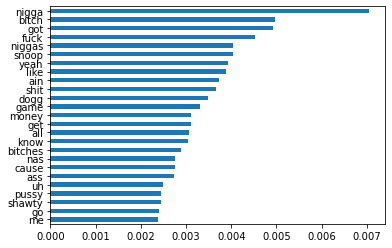

In [39]:
importances = pd.Series(random_best.feature_importances_, index=vectorizer.get_feature_names()).sort_values()
importances.tail(25).plot(kind='barh')

In [40]:
df_grouped.index

Index(['East', 'Mid-West', 'South', 'West'], dtype='object', name='region')

In [41]:
def create_wordcloud(corpus, colormap='Blues'):
    """Creates wordclouds for given text

    Args:
        corpus (str): Combined lyrics of all songs within each region
        colormap (str, optional): Color mapping of word cloud. Defaults to 'Blues'.

    Returns:
        [type]: [description]
    """
    text = corpus
    wordcloud = WordCloud(background_color="white",colormap=colormap).generate(text)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    return plt.show()
    


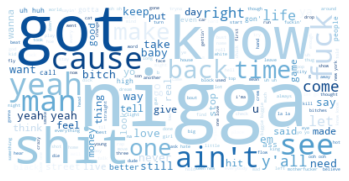

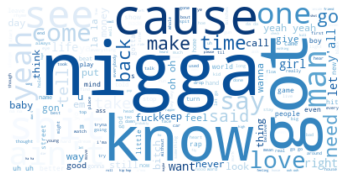

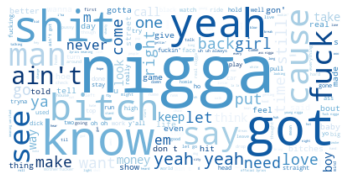

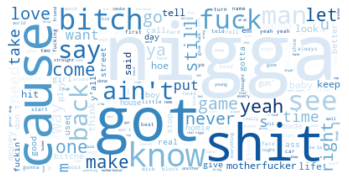

In [42]:
east_cloud = create_wordcloud(df_grouped.lyrics[0])
midwest_cloud = create_wordcloud(df_grouped.lyrics[1])
south_cloud = create_wordcloud(df_grouped.lyrics[2])
west_cloud = create_wordcloud(df_grouped.lyrics[3])

In [43]:
east_cloud

random_best
Training Accuracy: 0.9753357438016529
Testing Accuracy: 0.7511615900877646
Training Recall: 0.9753357438016529
Testing Recall: 0.7511615900877646

---------------

Train Confusion Matrix



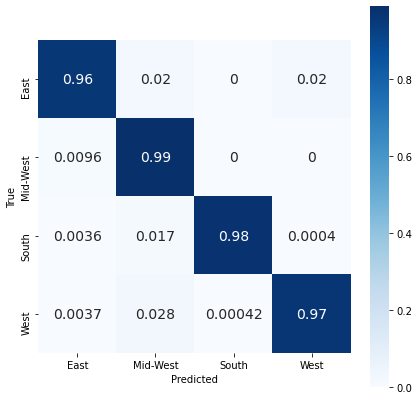

Test Confusion Matrix



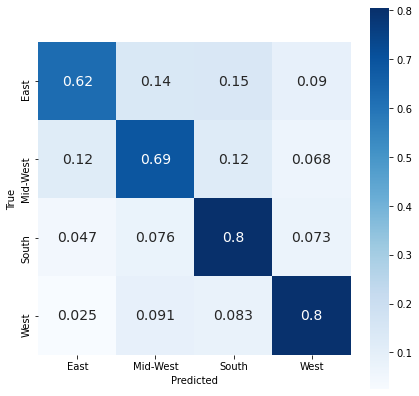


----------------

              precision    recall  f1-score   support

        East       0.63      0.62      0.63       268
    Mid-West       0.69      0.69      0.69       458
       South       0.77      0.80      0.79       619
        West       0.83      0.80      0.81       592

    accuracy                           0.75      1937
   macro avg       0.73      0.73      0.73      1937
weighted avg       0.75      0.75      0.75      1937



In [44]:
# print('baseline random forest')
# evaluate_model(rf, X_train, X_test)
# print('random forest_lemm')
# evaluate_model(rf_lemm, X_train_lemm, X_test)
print('random_best')
evaluate_model(random_best, X_train, X_test)
# print('random_best_lemm')
# evaluate_model(random_best_lemm, X_train_lemm, X_test)



# Conclusion
 I tuned the final random forest model and came out with a decent score at 75%. I think scrubbing the data to remove featured artists would be a good way to ensure that only the main artists lyrical content are included within the data.
 Another good way to increase accuracy would be getting additional data. It makes sense that the East and Mid-West regions have lower scores since those are the two regions where I have less data.